# Required functions for loading and processing data set

## Loading libraries

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import glob
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing hypopt library for grid search
# from hypopt import GridSearch

# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D

import warnings
warnings.filterwarnings('ignore')

## Loading images min-max

In [1]:
def load_image_minmax(inputPath):
    # initialize the list of column names in the CSV file and then
    # load it using Pandas
    cols = ["min", "max", "image_name","temperature","Cr","Co"]
    df = pd.read_csv(inputPath,header=None, names=cols)
    # return the data frame
    return df

## Processing of image min_max

In [13]:


def process_image_minmax(df, train, test):
    # initialize the column names of the continuous data
    continuous = ["min", "max"]
    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    
#     cs = MinMaxScaler()
#     trainContinuous = cs.fit_transform(train[continuous])
#     testContinuous = cs.transform(test[continuous])
    trainContinuous = train[continuous]
    testContinuous = test[continuous]
    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    # trainX = np.hstack([trainContinuous])
    # testX = np.hstack([testContinuous])
    # return the concatenated training and testing data
    trainX = np.array(trainContinuous)
    testX = np.array(testContinuous)
    return (trainX, testX)


## Extract image features by VGG16 convolutional layers

In [ ]:
def create_features(df, inputPath, pre_model):

    images = []

    # loop over the images
    for i in df['image_name']:
        imagePath = os.path.join(inputPath,i)
    # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)

        # add the image to the batch
        images.append(image)

    x = np.vstack(images)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return features_flatten

# Model development

## Loading libraries

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


## FC for extracted image features

In [2]:
def create_feature_model(dim, regress=False):
    model = Sequential()
    model.add(Dense(16, input_dim=dim, activation="relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation="relu"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    # return our model
    return model

## FC for combining output of CNN with numeric data (image min_max)

In [ ]:
def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    # return our model
    return model

# Compile the Model

In [47]:
#%%time

# import tensorflow as tf
# gpu = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu[0], True)

# import the necessary packages
from spinodalfunc import spinodal_datasets_new
from spinodalfunc import spinodal_models_new
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
import numpy as np
import argparse
import locale
import os
from sklearn.metrics import mean_squared_error, r2_score
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, GlobalAveragePooling2D
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", type=str, required=True,
#     help="path to input dataset of spinodal images")
# args = vars(ap.parse_args())

path='/home/labuser/Spinodal-Data/Spinodal_Dataset'
# construct the path to the input .csv file that contains information
# on each sample in the dataset and then load the dataset
print("[INFO] loading images min-max...")
inputPath = os.path.sep.join([path, "SpinodalInfo.csv"])
df = load_image_minmax(inputPath)

print("Data shape")
print(df.shape)

print("[INFO] loading spinodal images...")
images = create_features(df, path,pre_model = VGG16(weights="imagenet", include_top=False))

print("Image shape")
print(images.shape)
#print(df)
# load the images and then scale the pixel intensities to the
# range [0, 1]
# print("[INFO] loading spinodal images...")
# images = load_spinodal_images(df, path)
# images = images / 255.0
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
print("[INFO] processing data...")
#normalizer = preprocessing.Normalization()
#df["temperature"]=(df["temperature"]-df["temperature"].min())/(df["temperature"].max()-df["temperature"].min())
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

print("Train shape")
print(trainAttrX.shape)
print("Test shape")
print(testAttrX.shape)

# find the largest temperature in the training set and use it to
# scale our temperatures to the range [0, 1] (will lead to better
# training and convergence)

# construct the path to the input .csv file that contains information
# on each sample in the dataset and then load the dataset
# print("[INFO] loading images min-max...")
# inputPath = os.path.sep.join([args["dataset"], "SpinodalInfo.csv"])
# df = spinodal_datasets_new.load_image_minmax(inputPath)
# # load the images and then scale the pixel intensities to the
# # range [0, 1]

# #images = images / 255.0
# # partition the data into training and testing splits using 75% of
# # the data for training and the remaining 25% for testing
# print("[INFO] processing data...")
# split = train_test_split(df, images, test_size=0.25, random_state=42)
# (trainAttrX, testAttrX, trainImagesX, testImagesX) = split
# find the largest temperature in the training set and use it to
# scale our temperatures to the range [0, 1] (will lead to better
# training and convergence)
colY = ["temperature", "Cr", "Cr"]
# cs = MinMaxScaler()
# traincolY = cs.fit_transform(trainAttrX[colY])
# testcolY = cs.transform(testAttrX[colY])
# trainY = np.array(traincolY)
# testY = np.array(testcolY)
maxTemp = trainAttrX["temperature"].max()
trainAttrX["temperature"] = trainAttrX["temperature"] / maxTemp
testAttrX["temperature"] = testAttrX["temperature"] / maxTemp
trainY = np.array(trainAttrX[colY])
print("Train labels shape")
print(trainY.shape)
#print(testAttrX)
testY = np.array(testAttrX[colY])
print("Test labels shape")
print(testY.shape)
# process the image minmax data by performing min-max scaling
(trainAttrX, testAttrX) = process_image_minmax(df,trainAttrX, testAttrX)
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_feature_model(trainImagesX.shape[1], regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(3, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted temperature of the spinodal)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)
# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our temperature *predictions* and the *actual temperatures*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# train the model
print("[INFO] training model...")
history = model.fit(
    x=[trainAttrX, trainImagesX], y=trainY,
    validation_data=([testAttrX, testImagesX], testY),
    epochs=10000, batch_size=8, verbose=0)
# make predictions on the testing data
print("[INFO] predicting temperatures...")
preds = model.predict([testAttrX, testImagesX])
#print("Actual Temperature & Cr & Co ...")
print("Temperature accuracy ...")
print("R-squared:")
print(r2_score(testY[:,0], preds[:,0]))
print("MSE:")
print(mean_squared_error(testY[:,0], preds[:,0]))

print("Cr accuracy ...")
print("R-squared:")
print(r2_score(testY[:,1], preds[:,1]))
print("MSE:")
print(mean_squared_error(testY[:,1], preds[:,1]))

print("Co accuracy ...")
print("R-squared:")
print(r2_score(testY[:,2], preds[:,2]))
print("MSE:")
print(mean_squared_error(testY[:,2], preds[:,2]))

#print("Predicted Temperature & Cr & Co ...")
#print(preds)

# print("Actual Temperature...")
# print(testY)
# print("Predicted Temperature...")
# print(preds)
# compute the difference between the *predicted* temperatures and the
# *actual* temperatures, then compute the percentage difference and
# the absolute percentage difference

# diff = preds.flatten() - testY
# percentDiff = (diff / testY) * 100
# absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference

# mean = np.mean(absPercentDiff)
# std = np.std(absPercentDiff)

# finally, show some statistics on our model

# locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
# print("[INFO] avg. temperature: {}, std temperature: {}".format(df["temperature"].mean(),df["temperature"].std()))
# print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))


[INFO] loading images min-max...
Data shape
(454, 6)
[INFO] loading spinodal images...
Image shape
(454, 25088)
[INFO] processing data...
Train shape
(340, 6)
Test shape
(114, 6)
Train labels shape
(340, 3)
Test labels shape
(114, 3)
[INFO] training model...
[INFO] predicting temperatures...
Temperature accuracy ...
0.09154096147492263
0.0009980991793220662
Cr accuracy ...
0.9303969939832182
0.0003220933196252125
Co accuracy ...
0.9304313089798912
0.0003219345243112757


In [48]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

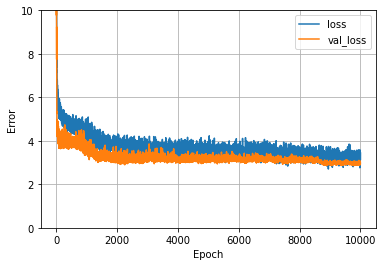

In [49]:
plot_loss(history)

In [50]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_26_input (InputLayer)     [(None, 25088)]      0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 16)           401424      dense_26_input[0][0]             
__________________________________________________________________________________________________
dense_24_input (InputLayer)     [(None, 2)]          0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 16)           64          dense_26[0][0]                   
____________________________________________________________________________________________

In [2]:
def parity_plot(x, y):
  plt.scatter(x, y, label='Data')
  plt.plot(x, x, color='k', label='Predictions')
#   plt.xlabel('Ground truth')
#   plt.ylabel('Predicted')
  lims = [0, 1]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)
  plt.xlabel('Groud truth', fontsize=18)
  plt.ylabel('Prediction', fontsize=18)
  plt.legend()

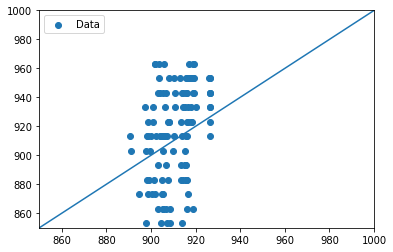

In [56]:
#parity_plot(preds[:,0]*963, testY[:,0]*963)
plt.scatter(preds[:,0]*963, testY[:,0]*963, label='Data')
#plt.plot(x, x, color='k', label='Predictions')
lims = [850, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.legend()

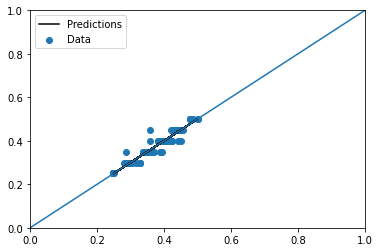

In [53]:
parity_plot(preds[:,1], testY[:,1])

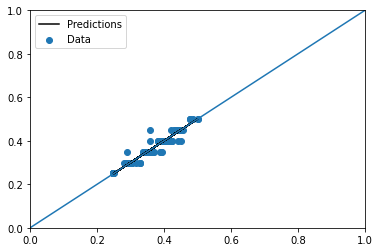

In [54]:
parity_plot(preds[:,2], testY[:,2])

In [55]:
df["temperature"].max()

963